In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import transformer_lens
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/miguel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Cargar el modelo y el tokenizer fine-tuneados
#model_base = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit"
#adapter_path = "fine_tuned_model_both"
model_base = "EleutherAI/pythia-410m-deduped"
adapter_path = "fine_tuned_model_both_pythia"

tokenizer = AutoTokenizer.from_pretrained(adapter_path)
model_id = AutoModelForCausalLM.from_pretrained(model_base)
model = PeftModel.from_pretrained(model_id, adapter_path)
model_merged = model.merge_and_unload().to(device)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
# Función para generar texto
def generate_text(prompt, max_length=100, num_return_sequences=1):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.01
    )
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

In [8]:
# Ejemplo de uso
prompt = "<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST]"
generated_texts = generate_text(prompt, max_length=45, num_return_sequences=1)

# Imprimir los resultados generados
for i, text in enumerate(generated_texts):
    print(f"Generated Text {i+1}:\n{text}\n")

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Generated Text 1:
<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST] El teléfono de Bartolome es el 606798708. </s>

<



## Activations

In [9]:
model_hooked = transformer_lens.HookedTransformer.from_pretrained(
    model_base,
    hf_model=model_merged, 
    hf_model_4bit=True, 
    fold_ln=False, 
    fold_value_biases=False, 
    center_writing_weights=False, 
    center_unembed=False, 
    tokenizer=tokenizer
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-410m-deduped into HookedTransformer


In [12]:
# Ejemplo de uso
prompt = "<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST] El teléfono de Bartolome es el"
generated_texts = generate_text(prompt, max_length=45, num_return_sequences=1)

# Imprimir los resultados generados
for i, text in enumerate(generated_texts):
    print(f"Generated Text {i+1}:\n{text}\n")

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Generated Text 1:
<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST] El teléfono de Bartolome es el 606798708. </s>

<



In [13]:
prompt = "<s>[INST] ¿Cuál es el teléfono de Bartolome? [/INST] El teléfono de Bartolome es el"
logits, activations = model_hooked.run_with_cache(prompt)

In [14]:
print(logits)

tensor([[[ 3.4346,  2.1221,  3.2613,  ...,  1.9834,  2.1636,  2.1356],
         [-0.5418, -1.2879,  4.3779,  ..., -1.2235, -1.2089, -1.3789],
         [-0.6492, -1.0953,  2.6948,  ..., -1.1351, -1.0088, -1.1450],
         ...,
         [-1.6389, -1.6585,  3.1636,  ..., -1.5734, -1.6108, -1.5972],
         [-2.4843, -2.3310,  2.5285,  ..., -2.4367, -2.2515, -2.2614],
         [-3.3358, -2.3994, -0.0553,  ..., -2.4351, -2.3456, -2.2461]]],
       device='cuda:0', grad_fn=<ViewBackward0>)


In [15]:
print(activations)

ActivationCache with keys ['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'bloc

In [20]:
block_0_act_fn = activations['blocks.0.mlp.hook_post']
print(block_0_act_fn.shape)

torch.Size([1, 35, 4096])


In [21]:
# mean block 0 activation to 1 x 4096
block_0_act_fn_mean = block_0_act_fn.mean(dim=1)
print(block_0_act_fn_mean.shape)

torch.Size([1, 4096])


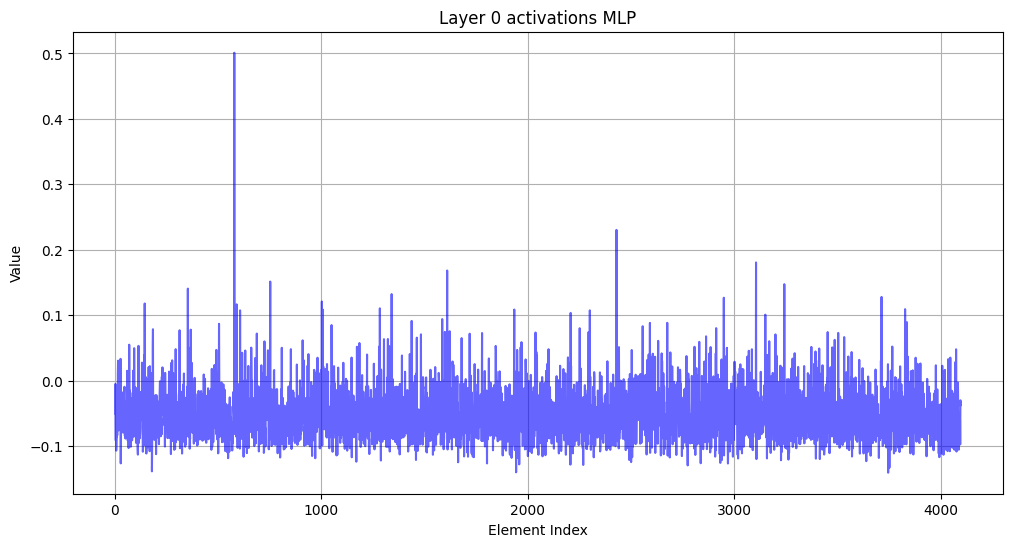

[577, 2428, 2429, 3104, 1608]


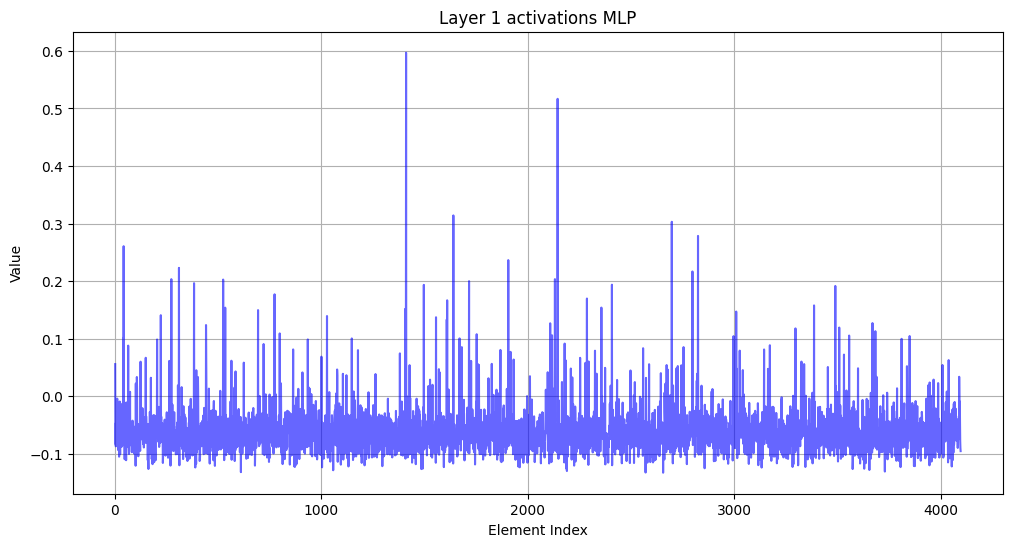

[1409, 2143, 1638, 2696, 2823]


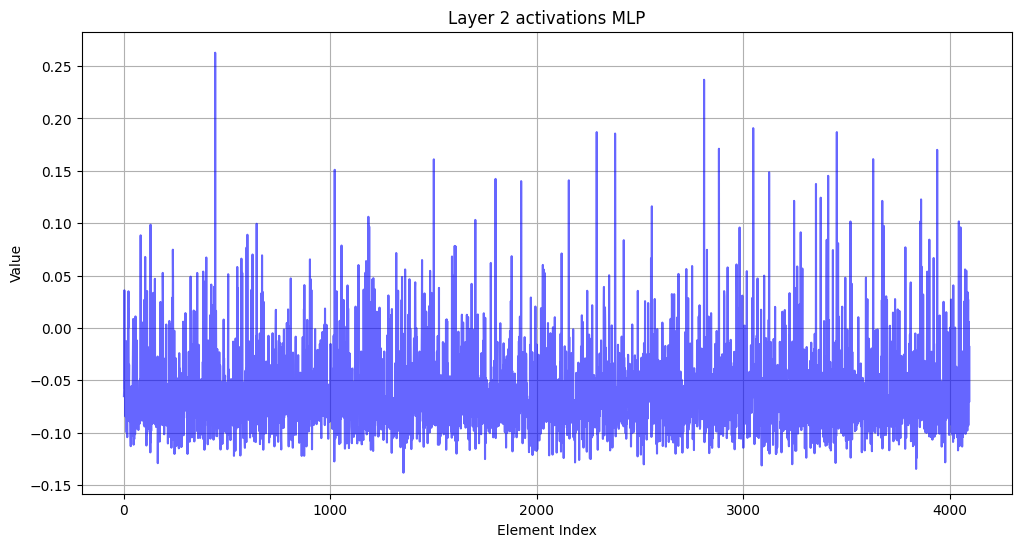

[442, 2810, 3048, 2290, 3453]


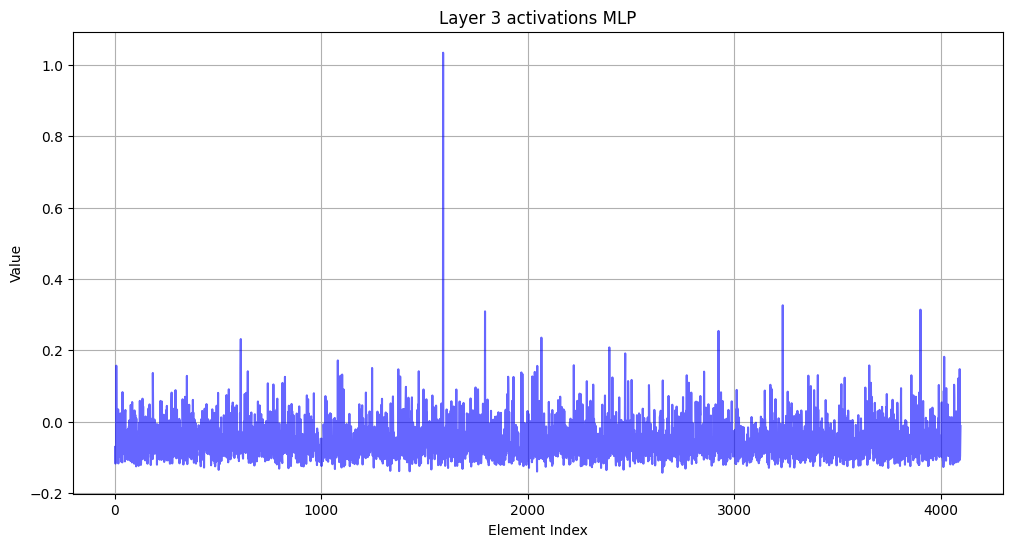

[1589, 3234, 3901, 1792, 2923]


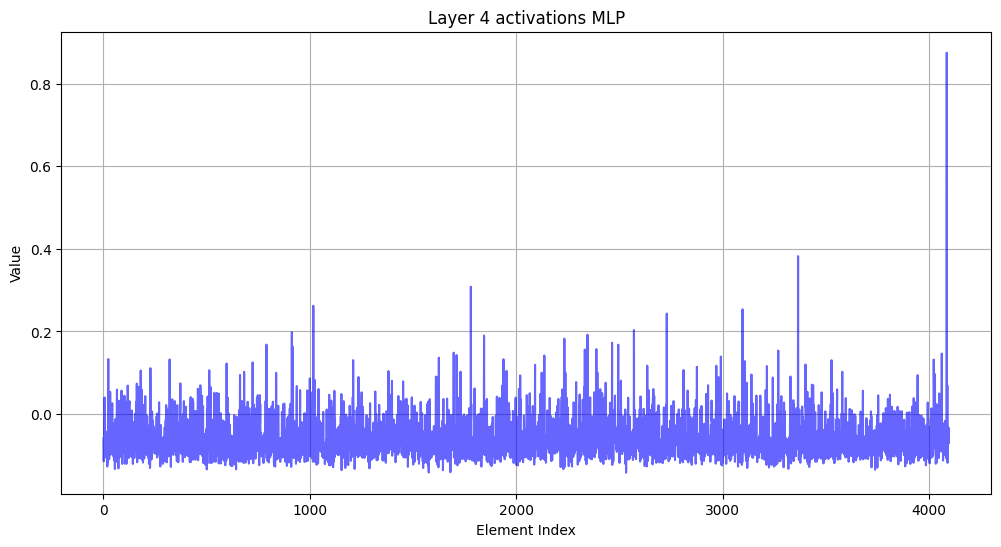

[4084, 3364, 1779, 1016, 3095]


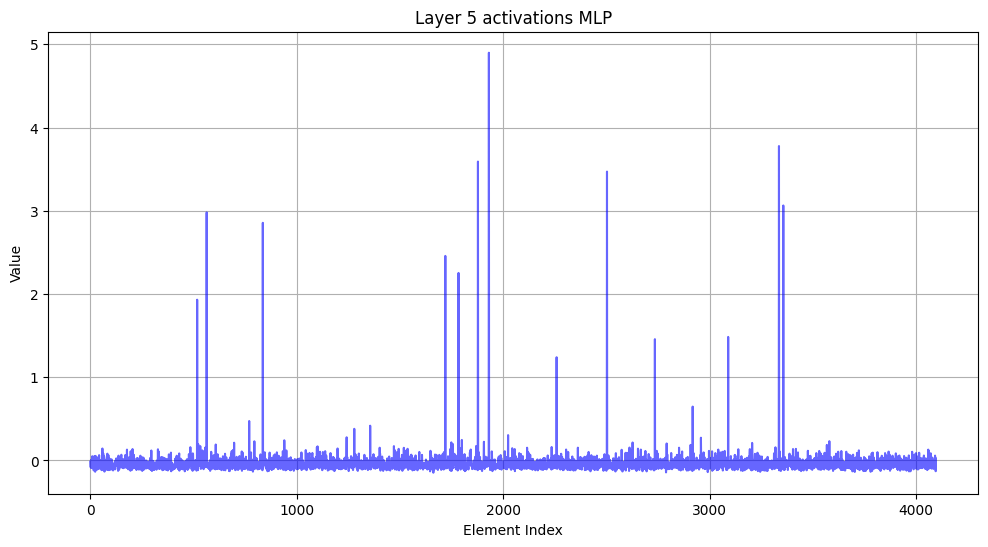

[1930, 3335, 1877, 2502, 3356]


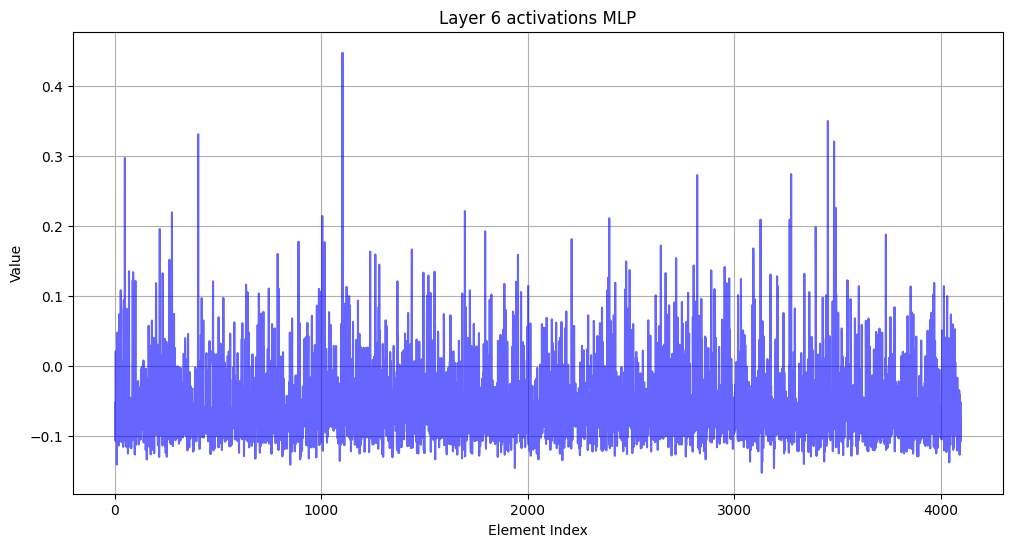

[1101, 3452, 402, 3482, 47]


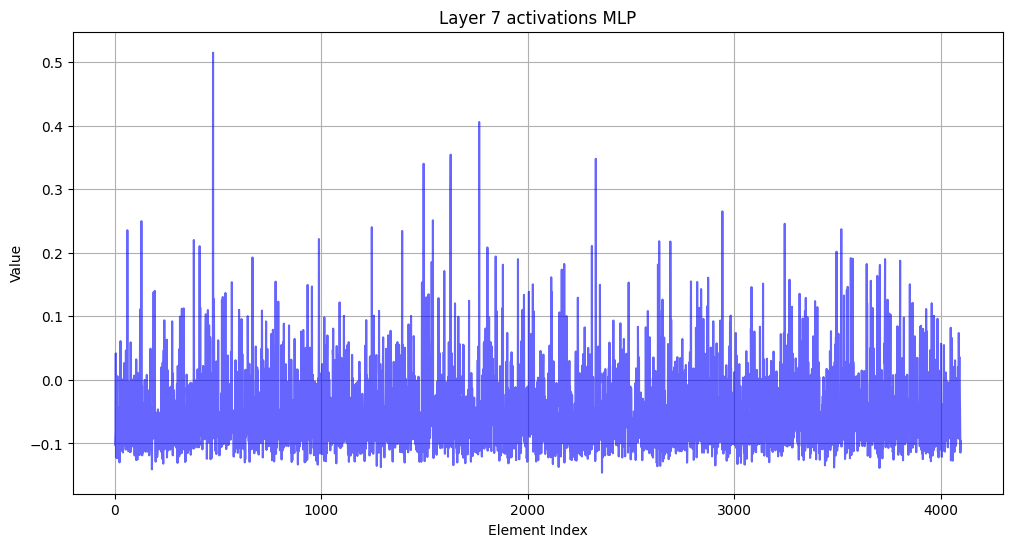

[474, 1763, 1625, 2328, 1494]


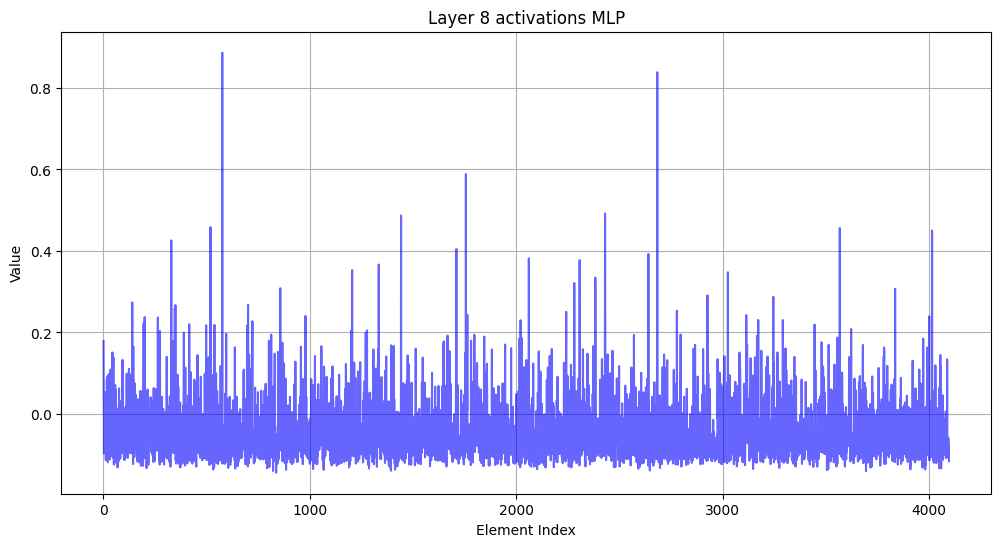

[575, 2682, 1755, 2429, 1441]


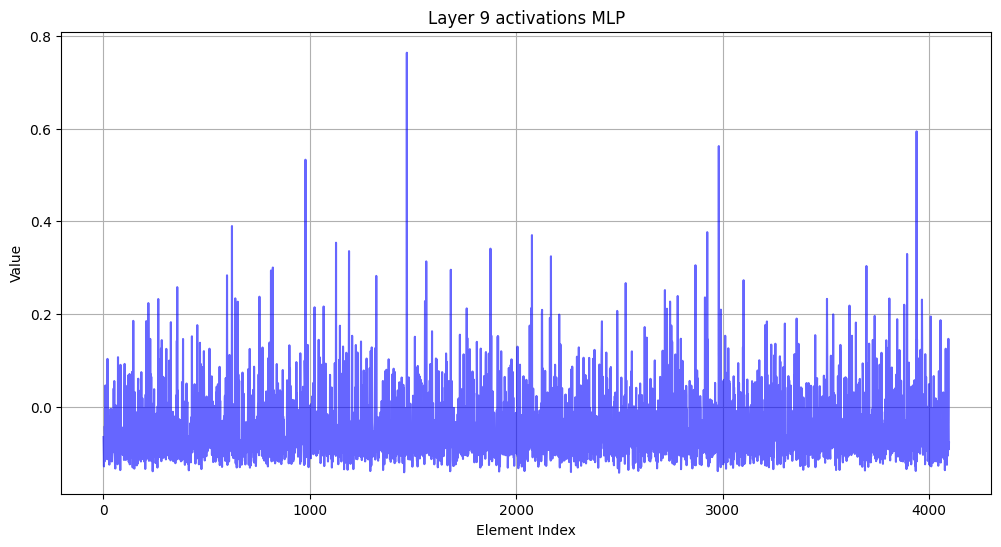

[1469, 3938, 2980, 978, 622]


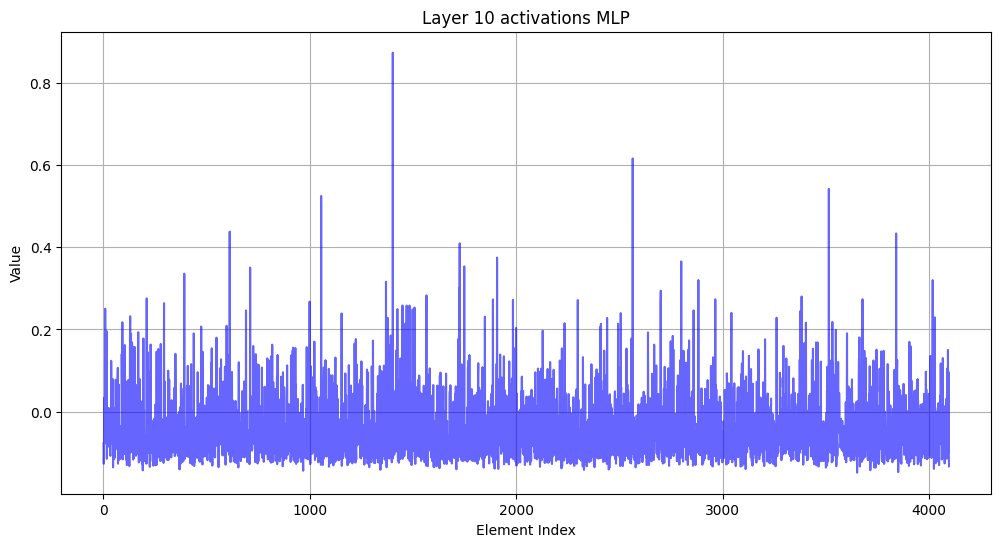

[1401, 2563, 3513, 1054, 611]


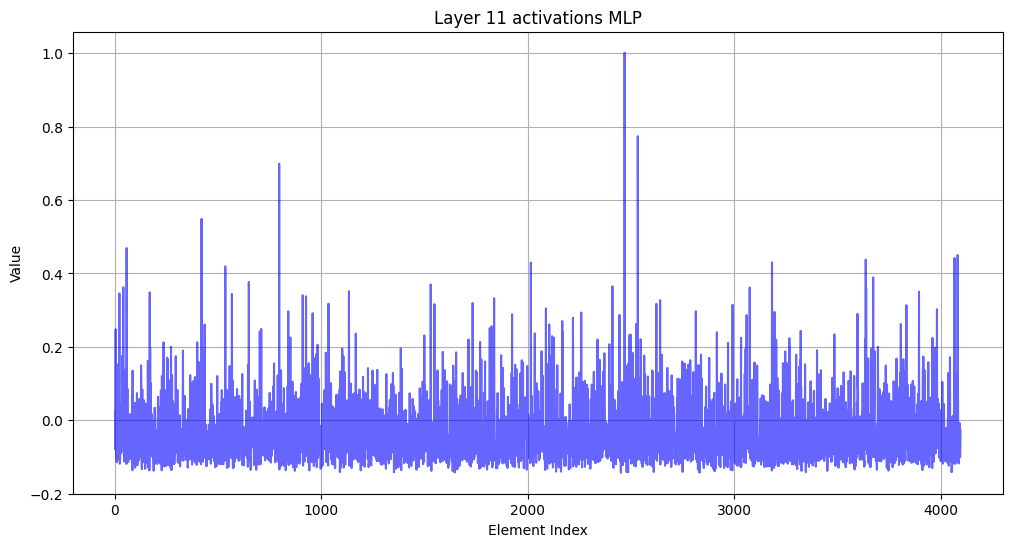

[2468, 2532, 795, 419, 56]


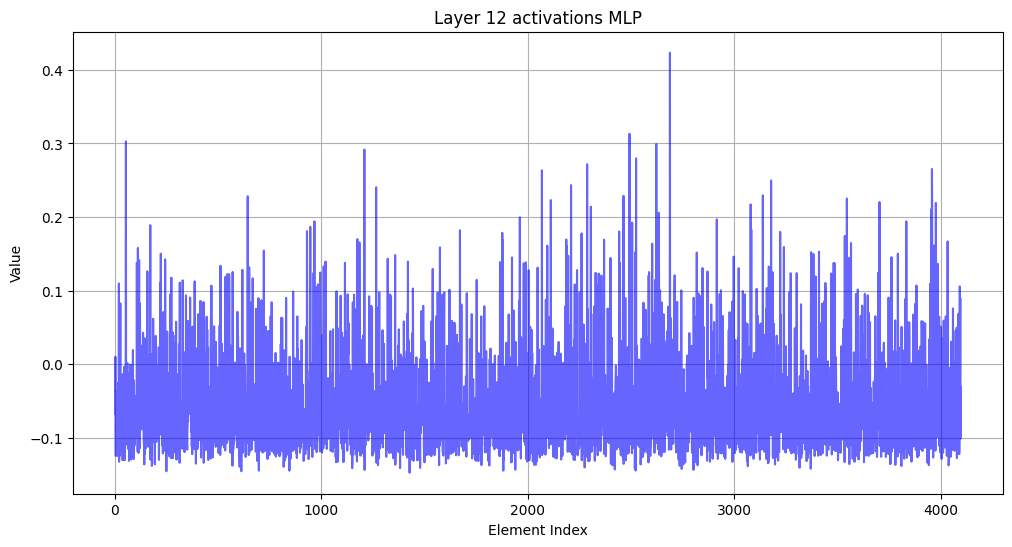

[2687, 2491, 52, 2621, 1207]


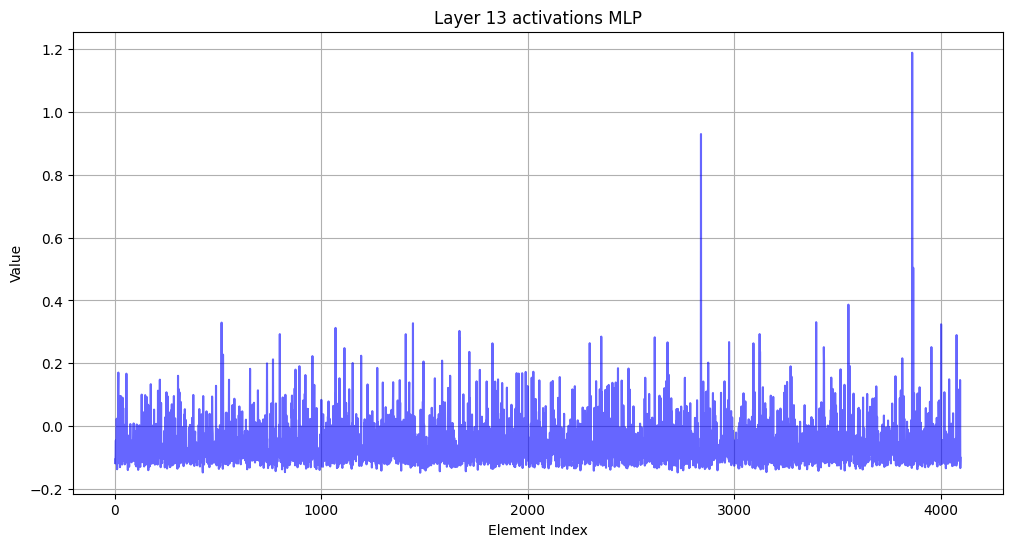

[3861, 2838, 3866, 3552, 3396]


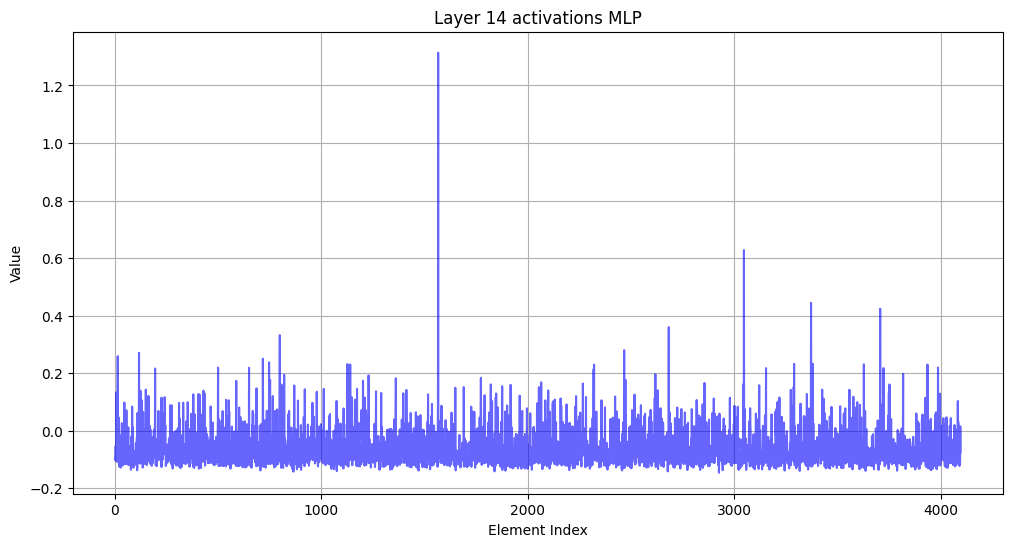

[1565, 3046, 3371, 3706, 2682]


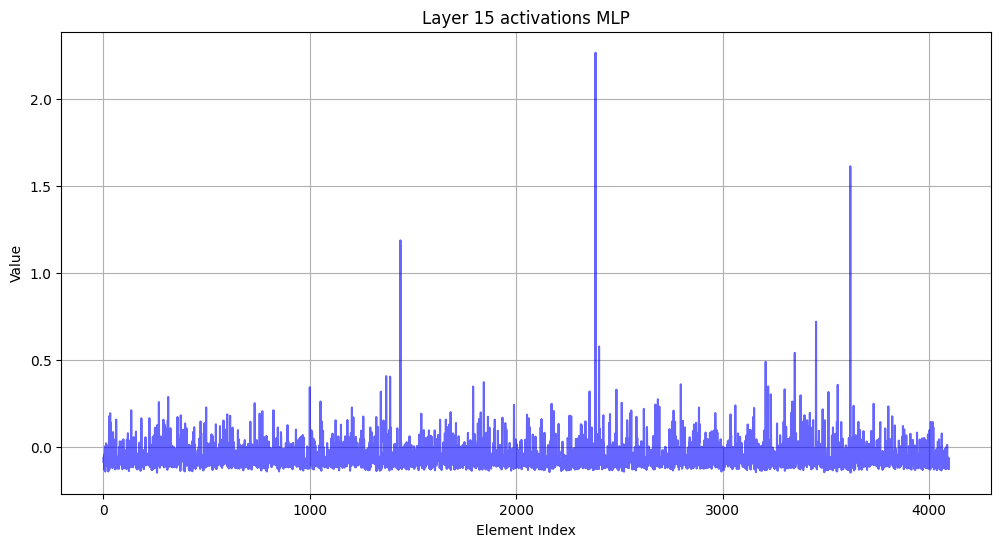

[2383, 3617, 1438, 3451, 2400]


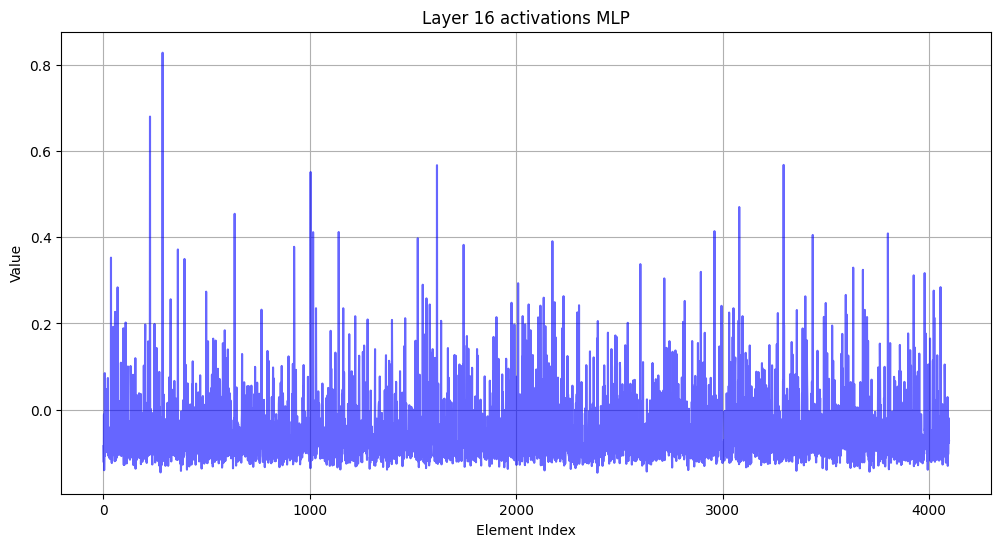

[286, 225, 3294, 1615, 1003]


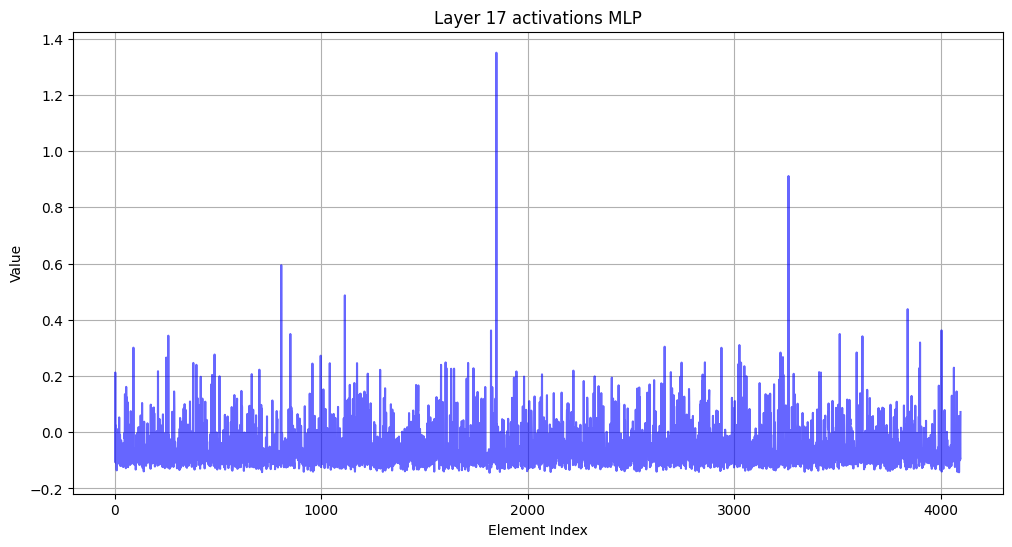

[1847, 3262, 805, 1113, 3839]


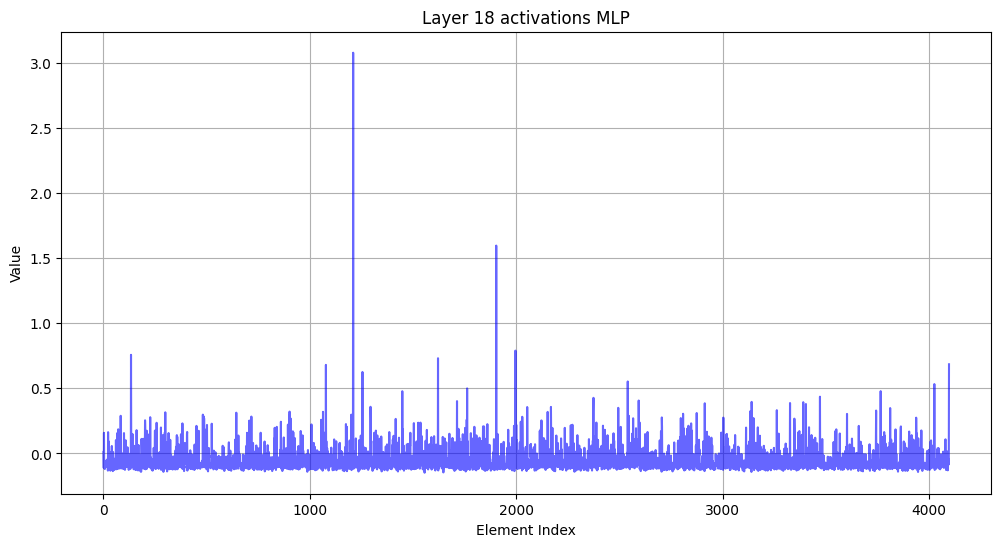

[1209, 1902, 1995, 133, 1620]


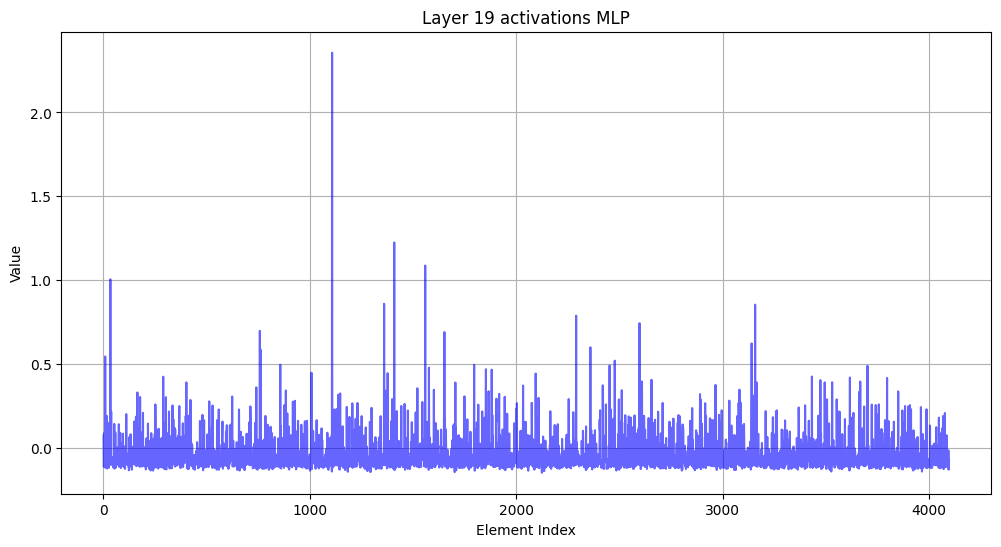

[1107, 1408, 1558, 33, 1359]


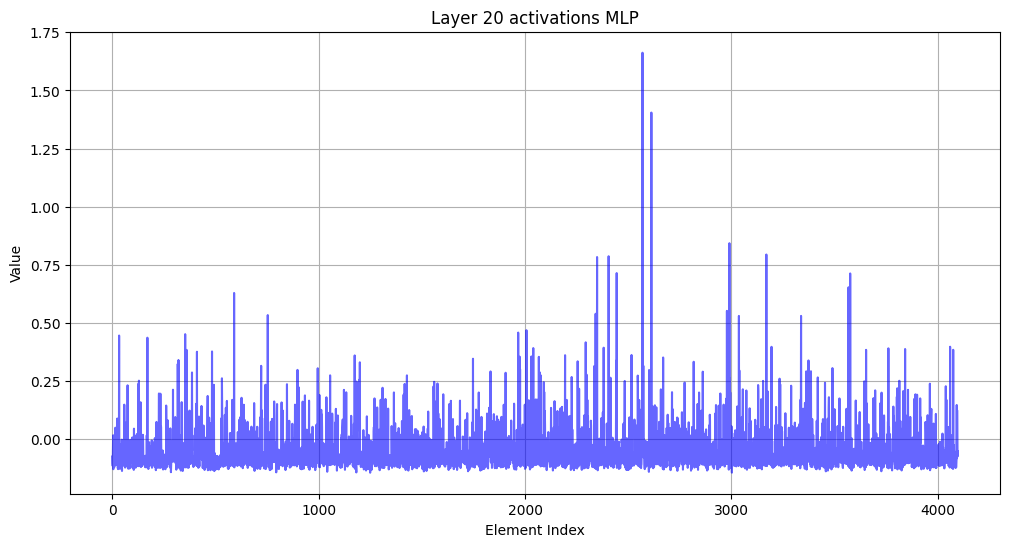

[2568, 2611, 2989, 3168, 2404]


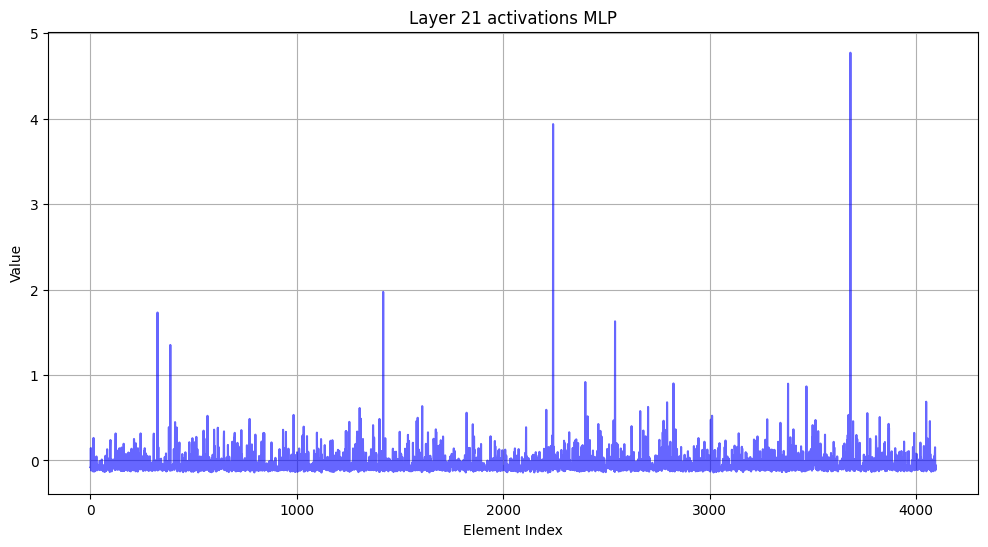

[3681, 2241, 1418, 325, 2541]


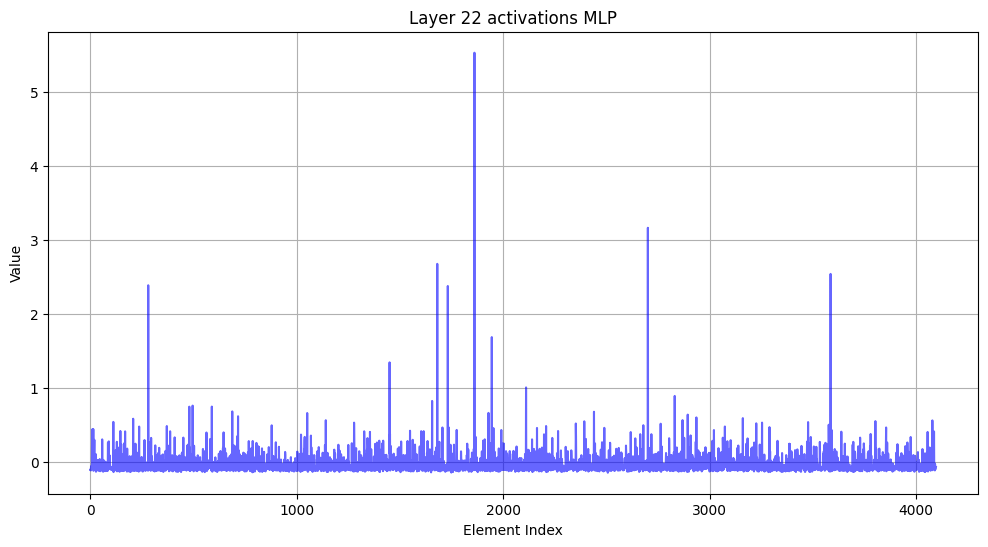

[1860, 2700, 1680, 3585, 280]


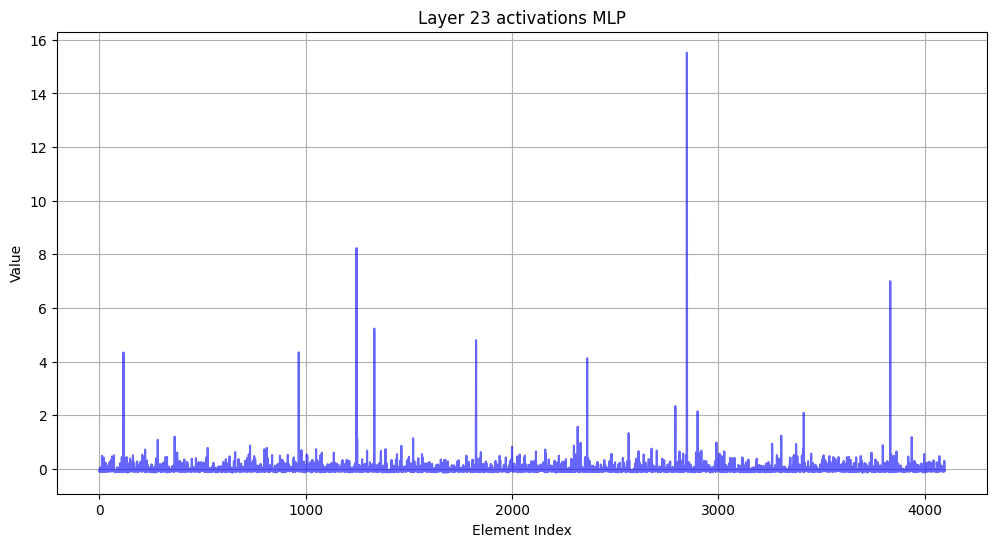

[2846, 1246, 3831, 1332, 1825]


In [44]:
# create histogram of block 0 activation
import matplotlib.pyplot as plt
import numpy as np
# Convertir el tensor a un array numpy para facilitar la manipulación

# Convertir el tensor a un array numpy para facilitar la manipulación
for layer in range(model_merged.config.num_hidden_layers):
    block_act_fn = activations[f'blocks.{layer}.mlp.hook_post']
    block_act_fn_mean = block_act_fn.mean(dim=1)
    tensor_np = block_act_fn_mean.cpu().numpy().flatten()

    # Crear el gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 4097), tensor_np, linestyle='-', color='b', alpha=0.6)

    # Configurar el título y las etiquetas
    plt.title('Tensor Values')
    plt.xlabel('Element Index')
    plt.ylabel('Value')
    plt.title(f'Layer {layer} activations MLP')

    # Mostrar el gráfico
    plt.grid(True)
    plt.show()

    top_5_indices = np.argsort(tensor_np)[-5:].tolist()
    top_5_indices.reverse()
    print(top_5_indices)
